### categorize data by label

In [24]:
activities = ['Walking', 'Running', 'Commute in bus', 'Eating using fork and spoon', 
             'Using mobile phone(texting)', 'Working on laptop', 'Sitting', 'Washing hands',
             'Eating with hand', 'Conversing while sitting', 'Elevator', 'Opening door',
             'Standing', 'Climbing upstairs', 'jogging']
columns = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Label']

In [3]:
import glob
import pandas as pd
def categorize():
    files = glob.glob("../DataSet/*Accelerometer.csv")
    data = pd.DataFrame()
    for name in files:
        data = data.append(pd.read_csv(name, usecols = columns))
    for i in range(len(activities)):
        tmp = data.loc[data['Label'] == i]
        tmp.to_csv("./categorized_data/" + activities[i] + ".csv", index=False)
# categorize()

In [4]:
def get_raw_data(activity):
    return pd.read_csv("./categorized_data/" + activity + ".csv")

### create segments with duration default 5

In [5]:
from tqdm import tqdm
def totoal_a(accs):
    import numpy as np
#     for i in range(len(accs)):
#         accs[i] = (accs[i]  * 3.0 / 63.0 - 1.5) * 9.8
    return np.sqrt(np.sum(map(lambda x: np.square(x), accs)))
    
def create_segs(data, duration):
    data = data.iloc[:, :3] # get x, y, z acceleration
    result = []
    for index, row in data.iterrows():
        result.append(totoal_a(list(row)[:3]))
    segs = []
    length = len(result)
    for i in tqdm(range(0, length, 32 * duration)):
        if i + duration * 32 <= length:
            segs.append(result[i:i + duration * 32])
    return segs

### calculate the medoid value
with the calculation of the distance of all the segementations, use fast relaxed dtw

In [1]:
# assume that each segment length is 5 second
import numpy as np
from fast_relaxed_dtw_v1 import fast_relaxed_dtw

def distance(seg1, seg2):
    result = 0.0;
    dist = lambda x,y : np.abs(x - y)
    distance, matrix = fast_relaxed_dtw(seg1, seg2, dist=dist, r=1)
    return distance
        
def find_medoid_seg(segs):
    length = len(segs)
    result = [0 for i in range(length)]
    table = [[-1 for i in range(length)] for i in range(length)] # initialize the table to all -1
    for i in tqdm(range(length)):
        for j in range(length):
            if i == j: 
                table[i][j] = 0
                continue
            elif table[j][i] != -1:  # using memoization
                result[i] += table[j][i]
            else:
                table[i][j] = distance(segs[i], segs[j])
                result[i] += table[i][j]
    min_medoid = min(result)
    for i in range(len(result)):
        if min_medoid == result[i]:
            return segs[i], min_medoid / len(segs)

### calculate the medoid value and the representation value for all the activities

In [15]:
import random
all_segments = []
medoids = []
represent = []
for i in range(len(activities)):
    segs = create_segs(get_raw_data(activities[i]), 5)
    all_segments.append(segs)
    seg, medoid = find_medoid_seg(segs)
    represent.append(seg)
    medoids.append(medoid)

100%|██████████| 5/5 [00:00<00:00, 39.75it/s]


### store the all_segments(list of segments by activities), represent(the represent segment for all activities), medoids(all the min medoid value for all activities)

In [16]:
import pickle
pickle_out = open("all_segs.pickle","wb")
pickle.dump(all_segments, pickle_out)
pickle_out.close()
pickle_out = open("represents.pickle","wb")
pickle.dump(represent, pickle_out)
pickle_out.close()
pickle_out = open("medoids.pickle","wb")
pickle.dump(medoids, pickle_out)
pickle_out.close()

### load the stored data

In [6]:
import random
import pickle
pickle_in = open("all_segs.pickle","rb")
all_segments = pickle.load(pickle_in)
pickle_in = open("represents.pickle","rb")
represent = pickle.load(pickle_in)
pickle_in = open("medoids.pickle","rb")
medoids = pickle.load(pickle_in)

In [12]:
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='mr_lancelot', api_key='WJcSyvZ1Ne3mTosBtlwc')
import plotly.graph_objs as go

In [25]:
average_medoid = []
for i in range(len(activities)):
    average_medoid.append(medoids[i] / len(all_segments[i]))
    
trace0 = go.Scatter(
    x=activities,
    y=average_medoid
)
data = [trace0]
py.iplot(data)

### expend all the segs 

In [103]:
# get value from list of indices
getVar = lambda List, indices: [List[i] for i in indices]
# k-smallest
def k_small(l, k, reverse = False):    
    new_l = [[i, l[i]] for i in range(len(l))]
    new_l = sorted(new_l, key = lambda x: x[-1])
    if reverse: new_l.reverse()
    return [i[1] for i in new_l[:k]], [i[0] for i in new_l[:k]]

In [108]:
sizes = [len(seg) for seg in all_segments]
k_l, indices = k_small(sizes, 5, True)

([935, 318, 194, 169, 94], [5, 0, 2, 6, 3])

In [70]:
all_seg_seperate = []
for i in indices:
    all_seg_seperate.extend(map(lambda x: [x, activities[i]], all_segments[i]))

###  use medoid to classify the activity
the classify will return a list of activity which match to the min_distance to all the represents

In [126]:
import numpy as np
def classify(represents, seg, k, activity=activities):
    dist = [-1 for i in range(len(represents))]
    for i in range(len(represents)):
        dist[i] = distance(represents[i], seg)
    small_dist, indices = k_small(dist, k)
    return getVar(activity, indices)

### evaluate the medoids, with 100 random data and return the percentage of correctness

In [208]:
def evaluate(size, k, indices = list(range(len(represent)))):  # k is the size of the random sample
    test = random.sample(all_seg_seperate, size)
    count = 0
    represents = getVar(represent, indices)
    activity = getVar(activities, indices)
    analysis = [[0,0] for i in range(len(activity))]
    mis_count = [[] for i in range(len(activity))]
    for i in range(size):
        result = classify(represents, test[i][0], k, activity)
#         for j in result:
#             assert j in activities
        correct_index = activity.index(test[i][1])
        classifies_index = activity.index(result[0])
        analysis[correct_index][0] += 1
        if test[i][1] in result: 
            count += 1
            analysis[classifies_index][1] += 1
        else:
            mis_count[correct_index].append(result[0])
#         print "correct is --->" + test[i][1]
#         print "clasify is --->" + str(result)
#         print "\n"
    print count / (k * 1.0)

In [234]:
def evaluate_one(activity, k, indices = list(range(len(represent)))):  # k is the size of the random sample
    test = all_segments[activities.index(activity)]
    count = 0
    represents = getVar(represent, indices)
    analysis = [[0, activities[i]] for i in indices]
    select_activity = getVar(activities, indices)
    for i in range(len(test)):
        result = classify(represents, test[i], k, select_activity)
        for j in result:
            assert j in select_activity 
        analysis[select_activity.index(result[0])][0] += 1
        analysis[select_activity.index(result[1])][0] += 1
        if activity in result: 
            count += 1
    print count / (len(test) * 1.0)
    for i in analysis:
        print i
    print activity
    print "\n"

In [130]:
getVar(activities, indices)

['Working on laptop',
 'Walking',
 'Commute in bus',
 'Sitting',
 'Eating using fork and spoon']

In [172]:
# the evaluation for the top 5, classify with 2 activities
random.seed(a=10)
for i in range(10):
    evaluate(100, 2, indices)

0.77
0.82
0.76
0.79
0.82
0.85
0.77
0.77
0.82
0.84


In [173]:
#the result for classify correctly
random.seed(a=10)
for i in range(10):
    evaluate(100, 1, indices)

0.48
0.48
0.42
0.42
0.5
0.53
0.53
0.43
0.44
0.54


In [188]:
random.seed(a=10)
for i in range(10):
    evaluate(100, 1, indices)

0.48
Working on laptop 62 36
Walking 20 1
Commute in bus 9 4
Sitting 9 7
Eating using fork and spoon 0 0
0.48
Working on laptop 64 36
Walking 18 0
Commute in bus 8 3
Sitting 10 9
Eating using fork and spoon 0 0
0.42
Working on laptop 59 28
Walking 25 1
Commute in bus 4 1
Sitting 12 12
Eating using fork and spoon 0 0
0.42
Working on laptop 60 33
Walking 25 1
Commute in bus 9 4
Sitting 6 4
Eating using fork and spoon 0 0
0.5
Working on laptop 59 31
Walking 21 3
Commute in bus 7 4
Sitting 13 12
Eating using fork and spoon 0 0
0.53
Working on laptop 61 34
Walking 16 1
Commute in bus 15 10
Sitting 8 8
Eating using fork and spoon 0 0


KeyboardInterrupt: 

In [196]:
random.seed(a=10)
for i in range(10):
    evaluate(100, 1, indices)

0.48
Working on laptop 62 36
['Commute in bus', 'Sitting', 'Commute in bus', 'Commute in bus', 'Commute in bus', 'Commute in bus', 'Commute in bus', 'Commute in bus', 'Eating using fork and spoon', 'Eating using fork and spoon', 'Eating using fork and spoon', 'Commute in bus', 'Commute in bus', 'Commute in bus', 'Sitting', 'Commute in bus', 'Sitting', 'Sitting', 'Eating using fork and spoon', 'Commute in bus', 'Commute in bus', 'Commute in bus', 'Eating using fork and spoon', 'Commute in bus', 'Commute in bus', 'Commute in bus']
Walking 20 1
['Eating using fork and spoon', 'Sitting', 'Eating using fork and spoon', 'Sitting', 'Sitting', 'Eating using fork and spoon', 'Sitting', 'Eating using fork and spoon', 'Sitting', 'Eating using fork and spoon', 'Eating using fork and spoon', 'Eating using fork and spoon', 'Eating using fork and spoon', 'Eating using fork and spoon', 'Eating using fork and spoon', 'Eating using fork and spoon', 'Sitting', 'Sitting', 'Sitting']
Commute in bus 9 4
['E

0.43
Working on laptop 61 30
['Commute in bus', 'Commute in bus', 'Commute in bus', 'Commute in bus', 'Commute in bus', 'Eating using fork and spoon', 'Commute in bus', 'Commute in bus', 'Sitting', 'Commute in bus', 'Sitting', 'Commute in bus', 'Commute in bus', 'Sitting', 'Commute in bus', 'Commute in bus', 'Sitting', 'Sitting', 'Commute in bus', 'Commute in bus', 'Commute in bus', 'Sitting', 'Commute in bus', 'Commute in bus', 'Eating using fork and spoon', 'Commute in bus', 'Commute in bus', 'Commute in bus', 'Sitting', 'Commute in bus', 'Eating using fork and spoon']
Walking 22 1
['Sitting', 'Sitting', 'Sitting', 'Sitting', 'Eating using fork and spoon', 'Sitting', 'Eating using fork and spoon', 'Eating using fork and spoon', 'Sitting', 'Eating using fork and spoon', 'Eating using fork and spoon', 'Sitting', 'Eating using fork and spoon', 'Sitting', 'Sitting', 'Eating using fork and spoon', 'Sitting', 'Eating using fork and spoon', 'Sitting', 'Eating using fork and spoon', 'Eating 

In [217]:
# the data for classify each activity
random.seed(a=10)
for i in range(len(indices)):
    evaluate_one(i, 1, indices)

0.549732620321 [514, 1, 278, 85, 57] 0
0.0660377358491 [5, 21, 12, 139, 141] 1
0.479381443299 [56, 0, 93, 0, 45] 2
0.923076923077 [9, 1, 3, 156, 0] 3
0.606382978723 [9, 0, 28, 0, 57] 4


In [231]:
# the data for classify each activity, guess 1 each time
random.seed(a=10)
for i in getVar(activities, indices):
    evaluate_one(i, 1, indices)

0.549732620321
[514, 'Working on laptop']
[1, 'Walking']
[278, 'Commute in bus']
[85, 'Sitting']
[57, 'Eating using fork and spoon']
Working on laptop


0.0660377358491
[5, 'Working on laptop']
[21, 'Walking']
[12, 'Commute in bus']
[139, 'Sitting']
[141, 'Eating using fork and spoon']
Walking


0.479381443299
[56, 'Working on laptop']
[0, 'Walking']
[93, 'Commute in bus']
[0, 'Sitting']
[45, 'Eating using fork and spoon']
Commute in bus


0.923076923077
[9, 'Working on laptop']
[1, 'Walking']
[3, 'Commute in bus']
[156, 'Sitting']
[0, 'Eating using fork and spoon']
Sitting


0.606382978723
[9, 'Working on laptop']
[0, 'Walking']
[28, 'Commute in bus']
[0, 'Sitting']
[57, 'Eating using fork and spoon']
Eating using fork and spoon




In [235]:
# the data for classifying each activity, guess 2 each time
random.seed(a=10)
for i in getVar(activities, indices):
    evaluate_one(i, 2, indices)

0.836363636364
[782, 'Working on laptop']
[86, 'Walking']
[813, 'Commute in bus']
[85, 'Sitting']
[104, 'Eating using fork and spoon']
Working on laptop


0.525157232704
[32, 'Working on laptop']
[167, 'Walking']
[128, 'Commute in bus']
[152, 'Sitting']
[157, 'Eating using fork and spoon']
Walking


0.948453608247
[133, 'Working on laptop']
[0, 'Walking']
[184, 'Commute in bus']
[0, 'Sitting']
[71, 'Eating using fork and spoon']
Commute in bus


0.92899408284
[12, 'Working on laptop']
[157, 'Walking']
[12, 'Commute in bus']
[157, 'Sitting']
[0, 'Eating using fork and spoon']
Sitting


0.765957446809
[33, 'Working on laptop']
[0, 'Walking']
[83, 'Commute in bus']
[0, 'Sitting']
[72, 'Eating using fork and spoon']
Eating using fork and spoon




In [117]:
# classify for 3 result, for all activities
random.seed(a=10)
for i in range(10):
    evaluate(100)

0.72
0.74
0.64
0.66
0.72
0.78
0.71
0.69


KeyboardInterrupt: 

### calculate the distance matrix for a random sample of segments
the visualization is not accurate, just a trival approach

In [17]:
import numpy as np
import string

test = random.sample(all_segments[0], 200)
length = len(test)
table = [[0 for i in range(length)] for i in range(length)]
for i in range(length):
    for j in range(length):
        if i == j:
            table[i][j] = 0
        elif i < j:
            table[i][j] = distance(test[i], test[j])
            table[j][i] = table[i][j]
        else:
            continue

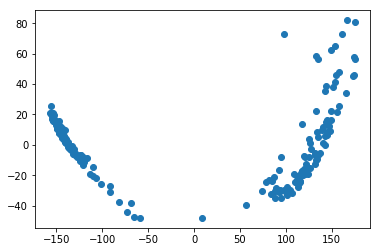

In [18]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
data = np.array(table)
pca = PCA(n_components=2)
coor = pca.fit_transform(data)
x, y = np.array(coor).T
plt.scatter(x, y)
plt.show()

### another approach for visualization clustering, will print edges as well, time consuming

In [42]:
import networkx as nx
dt = [('len', float)]
A = np.array(table)
A = A.view(dt)

G = nx.from_numpy_matrix(A)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),string.ascii_uppercase)))    
G = nx.drawing.nx_agraph.to_agraph(G)
# edges = list(G.edges())
# G.remove_edges_from(edges)
# G.node_attr.update(color="red", style="filled")
G.edge_attr.update(color="white")
G.draw('./out.png', format='png', prog='neato')

In [314]:
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
A = np.array([(0, 1,2,3),
               (1, 0, 0.9, 0.2),
               (2, 0.9, 0, 0.1),
               (3, 0.2, 0.1, 0)
               ]) * 20
pca = PCA(n_components=2)
X2d = pca.fit_transform(A)
X2d

array([[ 58.91121437,  -5.99548056],
       [ -2.64637306,  19.10169791],
       [-21.17254535,  -4.03570441],
       [-35.09229595,  -9.07051294]])

[[-5.75393585e+01  8.16496429e-01]
 [-5.81244262e+01 -8.13747648e-01]
 [ 1.15663785e+02 -2.74878088e-03]]


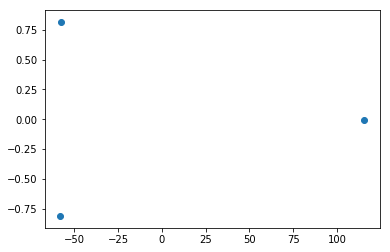

In [324]:
A = np.array([(0, 1, 100),
               (1, 0, 101),
               (100, 101, 0)
               ])
pca = PCA(n_components=2)
X2d = pca.fit_transform(A)
print X2d
x, y = np.array(X2d).T
plt.scatter(x,y)
plt.show();

In [38]:

dist = [1,2,3,4,5,6]
getVar(dist, [1,2])

[2, 3]